In [2]:
import pandas as pd
import plotly.express as px
from plotly.io import show

from fastf1.ergast import Ergast

In [3]:
ergast = Ergast()
races = ergast.get_race_schedule(2022)  # Races in year 2022
results = []

# For each race in the season
for rnd, race in races['raceName'].items():

    # Get results. Note that we use the round no. + 1, because the round no.
    # starts from one (1) instead of zero (0)
    temp = ergast.get_race_results(season=2022, round=rnd + 1)
    temp = temp.content[0]

    # If there is a sprint, get the results as well
    sprint = ergast.get_sprint_results(season=2022, round=rnd + 1)
    if sprint.content and sprint.description['round'][0] == rnd + 1:
        temp = pd.merge(temp, sprint.content[0], on='driverCode', how='left')
        # Add sprint points and race points to get the total
        temp['points'] = temp['points_x'] + temp['points_y']
        temp.drop(columns=['points_x', 'points_y'], inplace=True)

    # Add round no. and grand prix name
    temp['round'] = rnd + 1
    temp['race'] = race.removesuffix(' Grand Prix')
    temp = temp[['round', 'race', 'driverCode', 'points']]  # Keep useful cols.
    results.append(temp)

# Append all races into a single dataframe
results = pd.concat(results)
races = results['race'].drop_duplicates()

req         WARNING 	DEFAULT CACHE ENABLED! (2.53 GB) /Users/javi/Library/Caches/fastf1


In [4]:
results = results.pivot(index='driverCode', columns='round', values='points')
# Here we have a 22-by-22 matrix (22 races and 22 drivers, incl. DEV and HUL)

# Rank the drivers by their total points
results['total_points'] = results.sum(axis=1)
results = results.sort_values(by='total_points', ascending=False)
results.drop(columns='total_points', inplace=True)

# Use race name, instead of round no., as column names
results.columns = races

In [5]:
fig = px.imshow(
    results,
    text_auto=True,
    aspect='auto',  # Automatically adjust the aspect ratio
    color_continuous_scale=[[0,    'rgb(198, 219, 239)'],  # Blue scale
                            [0.25, 'rgb(107, 174, 214)'],
                            [0.5,  'rgb(33,  113, 181)'],
                            [0.75, 'rgb(8,   81,  156)'],
                            [1,    'rgb(8,   48,  107)']],
    labels={'x': 'Race',
            'y': 'Driver',
            'color': 'Points'}       # Change hover texts
)
fig.update_xaxes(title_text='')      # Remove axis titles
fig.update_yaxes(title_text='')
fig.update_yaxes(tickmode='linear')  # Show all ticks, i.e. driver names
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey',
                 showline=False,
                 tickson='boundaries')              # Show horizontal grid only
fig.update_xaxes(showgrid=False, showline=False)    # And remove vertical grid
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')     # White background
fig.update_layout(coloraxis_showscale=False)        # Remove legend
fig.update_layout(xaxis=dict(side='top'))           # x-axis on top
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # Remove border margins
fig
show(fig)

---

In [ ]:
import matplotlib.pyplot as plt

def championship(results):

    drivers = results.index.to_list()

    fig, ax = plt.subplots(figsize=(8, 5))


    for drv in drivers:
        drv_laps = session.laps.pick_drivers([drv])

        try:
            style = fastf1.plotting.get_driver_style(identifier=abb,
                                                    style=['color', 'linestyle'],
                                                    session=session)

            ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                    label=abb, **style)
            
        except IndexError:
            print('Driver not found. Probably DNS')
        
    ax.set_ylim([20.5, 0.5])
    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_xlabel('Lap')
    ax.set_ylabel('Position')
    ax.set_title(f'Position changes | {title}')

    ax.legend(bbox_to_anchor=(1.0, 1.02))
    plt.tight_layout()

In [23]:
df_acumulados = results.fillna(0).cumsum(axis=1)

In [27]:
session = fastf1.get_session(2022, 'Monza', 'R')  # Ejemplo: Gran Premio de Italia, Carrera
session.load()

core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info


req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']


req            INFO 	Using cached data for driver_info


No se encontró el estilo para el piloto: ALB
No se encontró el estilo para el piloto: HUL


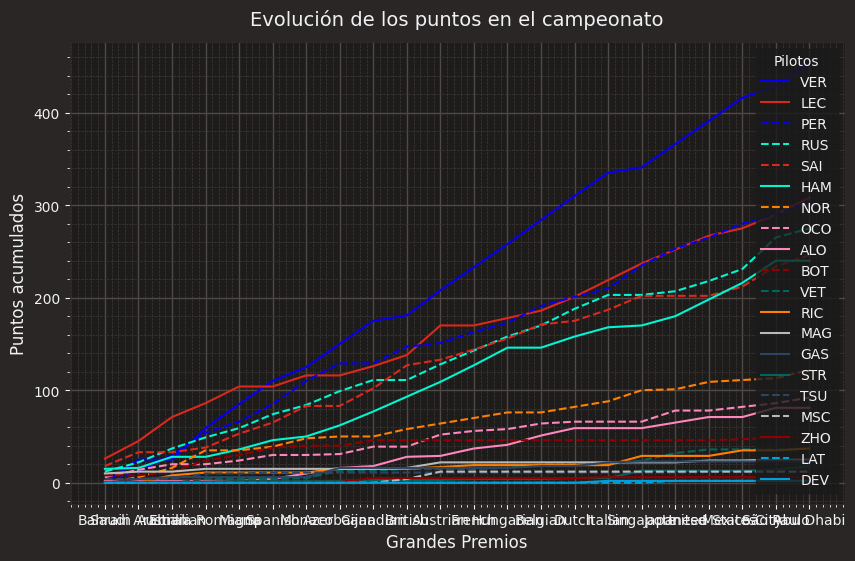

In [28]:
# Preparar el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Crear una lista de Grandes Premios
gps = df_acumulados.columns  # Columnas de los GP

# Graficar la evolución de los puntos con estilos de FastF1
for piloto in df_acumulados.index:
    puntos = df_acumulados.loc[piloto, gps]
    
    # Obtener estilo del piloto
    try:
        style = fastf1.plotting.get_driver_style(piloto, style=['color', 'linestyle'], session=session)
        ax.plot(gps, puntos, label=piloto, **style)
    except KeyError:
        print(f"No se encontró el estilo para el piloto: {piloto}")

# Personalización del gráfico
ax.set_title("Evolución de los puntos en el campeonato", fontsize=14)
ax.set_xlabel("Grandes Premios", fontsize=12)
ax.set_ylabel("Puntos acumulados", fontsize=12)
ax.legend(title="Pilotos", fontsize=10)
ax.grid(True)

# Mostrar el gráfico
plt.show()

Poner esto mejor